# Dependencies 

In [1]:
from sys import path
path.append('src/')

import cv2
import numpy as np
import tensorflow as tf
import pickle as pkl
import matplotlib.pyplot as plt
from datetime import datetime
from os.path import basename
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, BatchNormalization, Activation
from keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, UpSampling2D, GlobalAvgPool2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from skmultilearn.model_selection import iterative_train_test_split
from tensorflow.contrib.tensorboard.plugins import projector

%matplotlib inline

Using TensorFlow backend.


In [2]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss')

# Data Loading 

In [3]:
FILE_TRAIN_DUMP = 'data/train_dump.pkl'
FILE_VAL_DUMP = 'data/val_dump.pkl'

In [4]:
_, x_train, train_mrks = pkl.load(open(FILE_TRAIN_DUMP, 'rb'))
y_train = np.array([mrk_file.photo_reqs.values() for mrk_file in train_mrks])

print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)

(5211, 224, 224, 3) float32
(5211, 23) int32


In [5]:
_, x_val, val_mrks = pkl.load(open(FILE_VAL_DUMP, 'rb'))
y_val = np.array([mrk_file.photo_reqs.values() for mrk_file in val_mrks])

print(x_val.shape, x_val.dtype)
print(y_val.shape, y_val.dtype)

(571, 224, 224, 3) float32
(571, 23) int32


In [6]:
x = np.concatenate((x_train, x_val), axis=0)
y = np.concatenate((y_train, y_val), axis=0)
mrks = np.concatenate((train_mrks, val_mrks), axis=0)

print(x.shape, y.shape, mrks.shape)

(5782, 224, 224, 3) (5782, 23) (5782,)


In [7]:
np.random.seed(42)
x_train_idx, y_train, x_val_idx, y_val = iterative_train_test_split(np.arange(x.shape[0]).reshape(-1, 1), y, test_size=0.1)
x_train_idx = x_train_idx.ravel()
x_val_idx = x_val_idx.ravel()

x_train = x[x_train_idx]
x_val = x[x_val_idx]

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(5188, 224, 224, 3) (5188, 23)
(594, 224, 224, 3) (594, 23)


In [8]:
train_mrks = mrks[x_train_idx]
val_mrks = mrks[x_val_idx]

pkl.dump((x_train, x_val, train_mrks, val_mrks), open('data/autoencoder_samples.pkl', 'wb'), -1)

# Model Training 

In [9]:
x_train, x_val, _, _ = pkl.load(open('data/autoencoder_samples.pkl', 'rb'))
x_train /= 255.0
x_val /= 255.0

print(x_train.shape, x_train.dtype, x_train.min(), x_train.max())
print(x_val.shape, x_val.dtype, x_val.min(), x_val.max())

(5188, 224, 224, 3) float32 0.0 1.0
(594, 224, 224, 3) float32 0.0 1.0


In [10]:
def conv_bn(idx, prev_input, filters, name=None):
    conv_name = 'conv_' + str(idx)
    bn_name = 'bn_' + str(idx)
    act_name = 'relu_' + str(idx) if name is None else name
    
    conv = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=None, name=conv_name)(prev_input)
    conv = BatchNormalization(axis=-1, name=bn_name)(conv)
    conv = Activation('relu', name=act_name)(conv)
    return conv

def conv_bn_maxpool(idx, prev_input,  filters):
    pool_name = 'pool_' + str(idx)
    
    conv = conv_bn(idx, prev_input, filters)
    pool = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name=pool_name)(conv)
    return pool

def deconv_bn(idx, prev_input, filters, activation='relu'):
    bn_name = str(idx) + '_bn' 
    act_name = str(idx) + '_relu' 
    conv_name = str(idx) + '_conv' 
    
    deconv = Conv2DTranspose(filters, kernel_size=(3, 3), strides=(2, 2), padding='same', activation=None, name=conv_name)(prev_input)
    deconv = BatchNormalization(axis=-1, name=bn_name)(deconv)
    deconv = Activation(activation, name=act_name)(deconv)
    return deconv

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 224, 224, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 224, 224, 16)      64        
_________________________________________________________________
relu_1 (Activation)          (None, 224, 224, 16)      0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 112, 112, 16)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 112, 112, 32)      4640      
_________________________________________________________________
bn_2

5188/5188 [==============================] - 15s 3ms/step - loss: 0.0029 - val_loss: 0.0027

Epoch 00015: val_loss improved from 0.00295 to 0.00267, saving model to models/model_2019-6-17_12-29-19.hdf5
Epoch 16/50
5188/5188 [==============================] - 15s 3ms/step - loss: 0.0026 - val_loss: 0.0045

Epoch 00016: val_loss did not improve from 0.00267
Epoch 17/50
5188/5188 [==============================] - 15s 3ms/step - loss: 0.0027 - val_loss: 0.0022

Epoch 00017: val_loss improved from 0.00267 to 0.00224, saving model to models/model_2019-6-17_12-29-19.hdf5
Epoch 18/50
5188/5188 [==============================] - 15s 3ms/step - loss: 0.0024 - val_loss: 0.0024

Epoch 00018: val_loss did not improve from 0.00224
Epoch 19/50
5188/5188 [==============================] - 16s 3ms/step - loss: 0.0025 - val_loss: 0.0023

Epoch 00019: val_loss did not improve from 0.00224
Epoch 20/50
5188/5188 [==============================] - 15s 3ms/step - loss: 0.0024 - val_loss: 0.0022

Epoch 00020

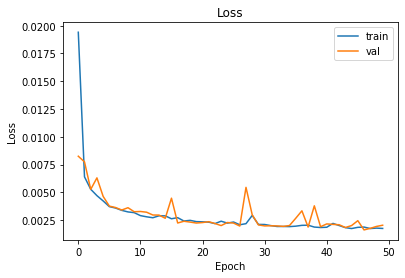

In [11]:
inputs = Input(shape=x_train.shape[1:], name='input')
pool_1 = conv_bn_maxpool(1, inputs, 16)
pool_2 = conv_bn_maxpool(2, pool_1, 32)
pool_3 = conv_bn_maxpool(3, pool_2, 64)
pool_4 = conv_bn_maxpool(4, pool_3, 128)
encode = conv_bn(5, pool_4, 256, name='encoded')

dec_4 = deconv_bn(4, encode, 128)
dec_3 = deconv_bn(3, dec_4, 64)
dec_2 = deconv_bn(2, dec_3, 32)
dec_1 = deconv_bn(1, dec_2, 16)
decoded = Conv2D(filters=3, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='sigmoid', name='decoded')(dec_1)

model = Model(inputs=inputs, outputs=decoded)
model.summary()

model.compile(optimizer='adam', loss='mean_squared_error')

now = datetime.now()
FILE_MODEL = 'models/model_{}-{}-{}_{}-{}-{}.hdf5'.format(now.year, now.month, now.day, now.hour, now.minute, now.second)
list_callbacks = [ModelCheckpoint(FILE_MODEL, monitor='val_loss', verbose=1, save_best_only=True), 
                  EarlyStopping(monitor='val_loss', patience=10, verbose=1)]

hist = model.fit(x_train, x_train, batch_size=32, epochs=50, validation_data=(x_val, x_val), callbacks=list_callbacks)
plot_loss(hist)

In [12]:
model = load_model(FILE_MODEL)
y_pred = model.predict(x_val)

print(y_pred.shape, y_pred.dtype, y_pred.min(), y_pred.max())

(594, 224, 224, 3) float32 0.006381184 0.99999475


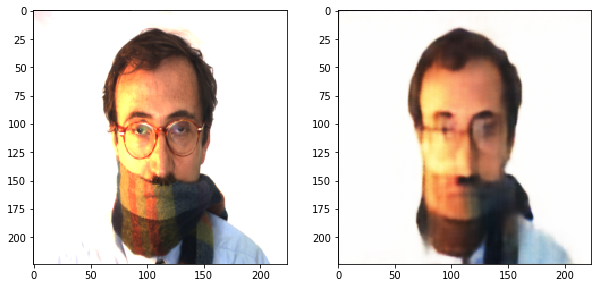

In [13]:
n_images = x_val.shape[0]
index = np.random.choice(range(n_images))

im_orig = x_val[index]
im_pred = y_pred[index]

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(im_orig[:, :, ::-1])

plt.subplot(1, 2, 2)
plt.imshow(im_pred[:, :, ::-1])

# Embeddings Visualization 

### Metadata 

In [14]:
_, data, _, mrks = pkl.load(open('data/autoencoder_samples.pkl', 'rb'))

image_files = [basename(mrk.file_path) for mrk in mrks.ravel()]
print(len(image_files))
print(data.shape)

594
(594, 224, 224, 3)


In [15]:
metadata_file = open('logs/metadata.tsv', 'w')
for file in image_files:
    metadata_file.write(file+'\n')
metadata_file.close()

### Image Sprite

In [16]:
def images_to_sprite(data):
    """Creates the sprite image along with any necessary padding
    Args:
      data: NxHxW[x3] tensor containing the images.
    Returns:
      data: Properly shaped HxWx3 image with any necessary padding.
    """
    if len(data.shape) == 3:
        data = np.tile(data[...,np.newaxis], (1,1,1,3))
    data = data.astype(np.float32)
    min_data = np.min(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) - min_data).transpose(3,0,1,2)
    max_data = np.max(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) / max_data).transpose(3,0,1,2)

    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, 0), (0, 0)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=0)
    
    # Tile the individual thumbnails into an image.
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    data = (data * 255).astype(np.uint8)
    return data

In [17]:
im_sprite = images_to_sprite(data)
print(im_sprite.shape)

cv2.imwrite('logs/sprites.png', im_sprite)

(5600, 5600, 3)


True

### Embeddings 

In [18]:
model = load_model(FILE_MODEL)

embeddings = GlobalAvgPool2D(name='embeddings')(model.get_layer(name='encoded').output)

model_emb = Model(inputs=model.inputs, outputs=embeddings)
model_emb.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 224, 224, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 224, 224, 16)      64        
_________________________________________________________________
relu_1 (Activation)          (None, 224, 224, 16)      0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 112, 112, 16)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 112, 112, 32)      4640      
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 112, 112, 32)      128       
__________

In [19]:
emb_vectors = model_emb.predict(data)
print(emb_vectors.shape)

(594, 256)


### Tensorboard 

In [20]:
sess = tf.InteractiveSession()

tf_embeddings = tf.Variable(emb_vectors, name='embeddings')
summary_writer = tf.summary.FileWriter('logs')

config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = tf_embeddings.name
embedding.metadata_path = 'metadata.tsv'
embedding.sprite.image_path = 'sprites.png'
embedding.sprite.single_image_dim.extend([224, 224])

projector.visualize_embeddings(summary_writer, config)

saver = tf.train.Saver([tf_embeddings])
sess.run(tf_embeddings.initializer)
saver.save(sess, 'logs/embeddings.ckpt')

sess.close()